In [1]:
import random
import torch
import gc
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from torch.nn import functional as F
from transformers import logging
logging.set_verbosity_error()

# model_name = 'flax-community/papuGaPT2'
model_name = 'eryk-mazus/polka-1.1b' # Context size: 2,048 tokens.
device = 'cpu'
set_seed(42)

/home/patryk/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
gc.collect()

145

In [3]:
def generate_examples(digits, n_exampels, operator_string):
    assert operator_string in {"*", "+", "-"}
    res = list()
    counter = n_exampels
    min_number = 10**(digits-1)
    max_number = 10**digits - 1

    while counter > 0:
        num1 = random.randint(min_number, max_number)
        num2 = random.randint(min_number, max_number)
        res.append(f"{num1} {operator_string} {num2} = {eval(f"{num1} {operator_string} {num2}")}")
        counter -= 1
    return '\n'.join(res)

generate_examples(1, 10, "-")

'2 - 1 = 1\n5 - 4 = 1\n4 - 3 = 1\n2 - 9 = -7\n2 - 7 = -5\n1 - 1 = 0\n2 - 4 = -2\n4 - 9 = -5\n1 - 9 = -8\n4 - 9 = -5'

In [30]:
def perform_test(digits, few_shot__examples, operator_string):
    assert operator_string in {"*", "+", "-"}
    correct = 0
    incorrect = 0
    start_prompt = f"Przykładowe dodawania liczb\n{generate_examples(digits, few_shot__examples, operator_string)}\n"

    for num1 in range(10**(digits-1) + 1):
        for num2 in range(10**digits):
            prompt = start_prompt + f"{num1} {operator_string} {num2} =" # nie wiem czy dawac spacje na koniec
            inputs = tokenizer(prompt, return_tensors="pt")
            outputs = model.generate(**inputs, max_length=150, max_new_tokens=(digits*2)+1)
            result = tokenizer.decode(outputs[0], skip_special_tokens=True)

            if bool(eval(result.strip().split('\n')[-1].replace("=", '=='))): correct += 1
            else: incorrect += 1

    return correct, incorrect

In [31]:
def plot_results(correct, incorrect):
    # Dane do wykresu
    categories = ['Correct', 'Incorrect']
    values = [correct, incorrect]

    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=['green', 'red'])
    plt.xlabel('Categories')
    plt.ylabel('Number of Answers')
    plt.title('Comparison of Correct and Incorrect Answers')
    plt.ylim(0, max(values) + 10)  # Ustawienie limitu osi Y

    # Dodanie wartości na słupkach
    for i, value in enumerate(values):
        plt.text(i, value + 1, str(value), ha='center')

    # Wyświetlenie wykresu
    plt.show()

In [ ]:
res = {"addition": {}, "subtraction": {}, "multiplication": {}}

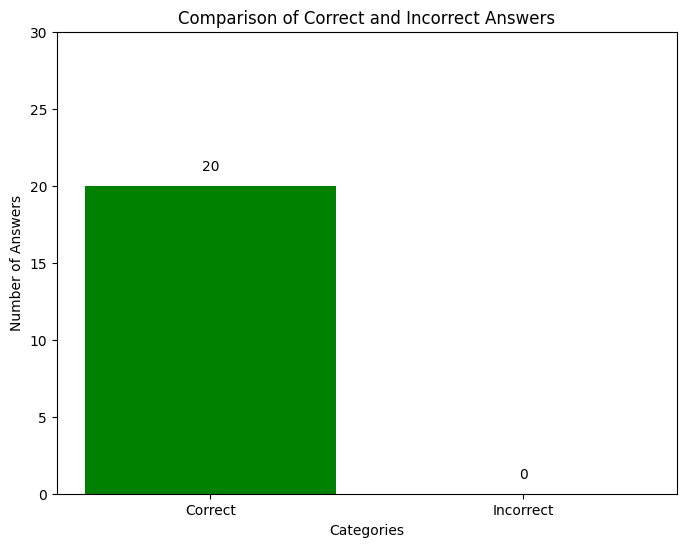

In [32]:
for i in range(1, 3):
    res["addidtion"][i] = perform_test(digits=1, few_shot__examples=10, operator_string="+")
    res["subtraction"][i] = perform_test(digits=1, few_shot__examples=10, operator_string="+")
    res["multiplication"][i] = perform_test(digits=1, few_shot__examples=10, operator_string="+")